# teleco churn prediction using machine learning #

## 1. Exploration et préparation des données

### préparation des données

In [87]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "blastchar/telco-customer-churn",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/tmp/ipykernel_47863/1365488764.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [88]:
print("First 5 records:", df.head())

First 5 records:    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies    

In [89]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [90]:
#القيم الفريدة لكل عمود
print("\nUnique values for each column:\n")
for col in df.columns:
    if col != 'customerID':
        print(f"{col}: {df[col].unique()}\n")


Unique values for each column:

gender: ['Female' 'Male']

SeniorCitizen: [0 1]

Partner: ['Yes' 'No']

Dependents: ['No' 'Yes']

tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

PhoneService: ['No' 'Yes']

MultipleLines: ['No phone service' 'No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes' 'No internet service']

OnlineBackup: ['Yes' 'No' 'No internet service']

DeviceProtection: ['No' 'Yes' 'No internet service']

TechSupport: ['No' 'Yes' 'No internet service']

StreamingTV: ['No' 'Yes' 'No internet service']

StreamingMovies: ['No' 'Yes' 'No internet service']

Contract: ['Month-to-month' 'One year' 'Two year']

PaperlessBilling: ['Yes' 'No']

PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

MonthlyCharges: [

### data cleaning & preprocessing

In [91]:
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Senior', 0: 'Genior'})

In [92]:
# Initialize counters
dropped_rows_phoneservice = 0
dropped_rows_internetservice = 0

# For PhoneService and MultipleLines
mask_phone = (df['PhoneService'] == 'No') & (df['MultipleLines'] != 'No phone service')
dropped_rows_phoneservice = mask_phone.sum()
df = df[~mask_phone]

# For InternetService and related columns
internet_related_cols = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
mask_internet = (df['InternetService'] == 'No')
for col in internet_related_cols:
    mask = mask_internet & (df[col] != 'No internet service')
    dropped_rows_internetservice += mask.sum()
    df = df[~mask]

print(f"Dropped rows due to PhoneService inconsistency: {dropped_rows_phoneservice}")
print(f"Dropped rows due to InternetService inconsistency: {dropped_rows_internetservice}")

Dropped rows due to PhoneService inconsistency: 0
Dropped rows due to InternetService inconsistency: 0


In [93]:
import pandas as pd
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isnull().sum())

11


In [94]:
df = df.dropna(subset=['TotalCharges'])

In [95]:
#drop rows where 'tenure' is 0 but 'TotalCharges' is not 0
df = df[~((df['tenure'] == 0) & (df['TotalCharges'] != 0))]

In [96]:
from sklearn.preprocessing import LabelEncoder

# إنشاء نسخة من البيانات الأصلية
df_clean = df.copy()

# One-hot encode PaymentMethod and InternetService
df_clean = pd.get_dummies(df_clean, columns=['PaymentMethod', 'InternetService'], drop_first=True)

# ترميز المتغيرات النوعية
le = LabelEncoder()
for column in df_clean.columns:
    if df_clean[column].dtype == 'object' and column != 'customerID':
        df_clean[column] = le.fit_transform(df_clean[column])


In [97]:
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7032 non-null   object 
 1   gender                                 7032 non-null   int64  
 2   SeniorCitizen                          7032 non-null   int64  
 3   Partner                                7032 non-null   int64  
 4   Dependents                             7032 non-null   int64  
 5   tenure                                 7032 non-null   int64  
 6   PhoneService                           7032 non-null   int64  
 7   MultipleLines                          7032 non-null   int64  
 8   OnlineSecurity                         7032 non-null   int64  
 9   OnlineBackup                           7032 non-null   int64  
 10  DeviceProtection                       7032 non-null   int64  
 11  TechSuppo

### data visualisation

**variable categorial**

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  ax = sns.barplot(


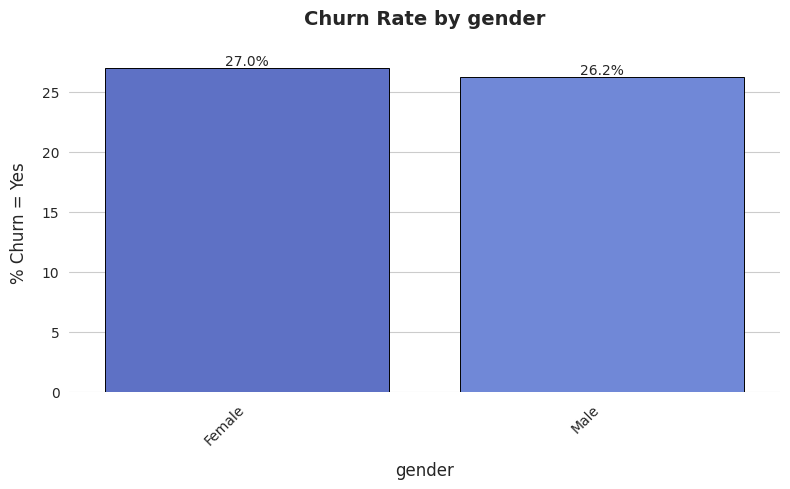

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  ax = sns.barplot(


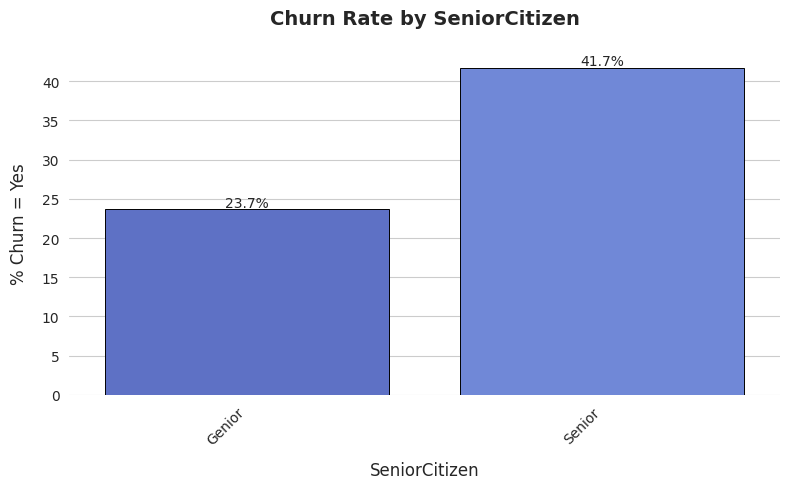

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  ax = sns.barplot(


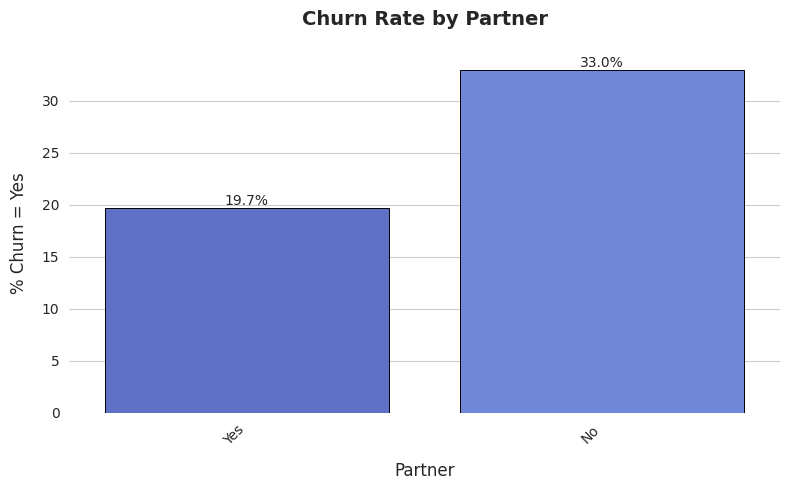

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  ax = sns.barplot(


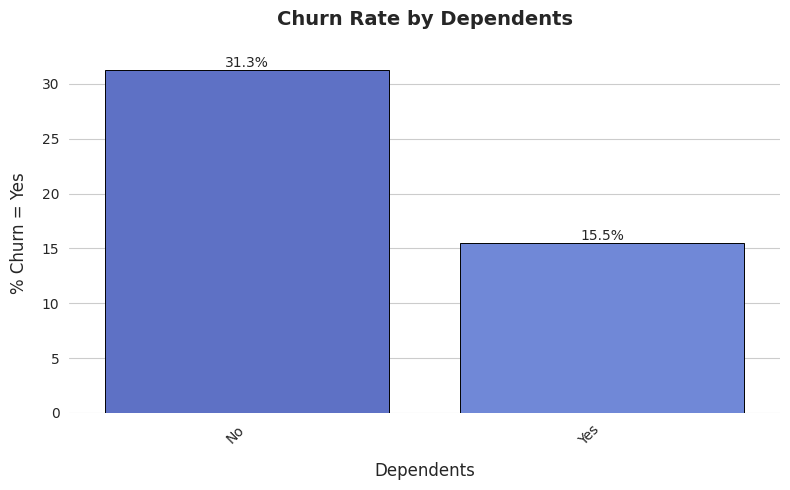

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  ax = sns.barplot(


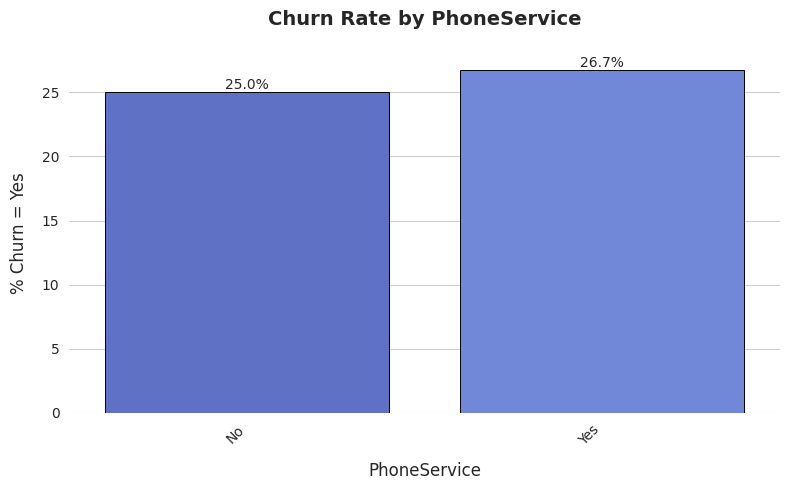

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


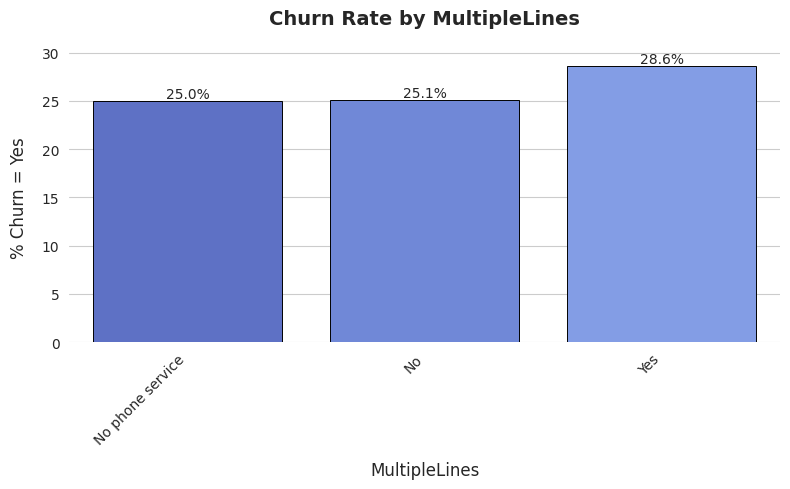

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


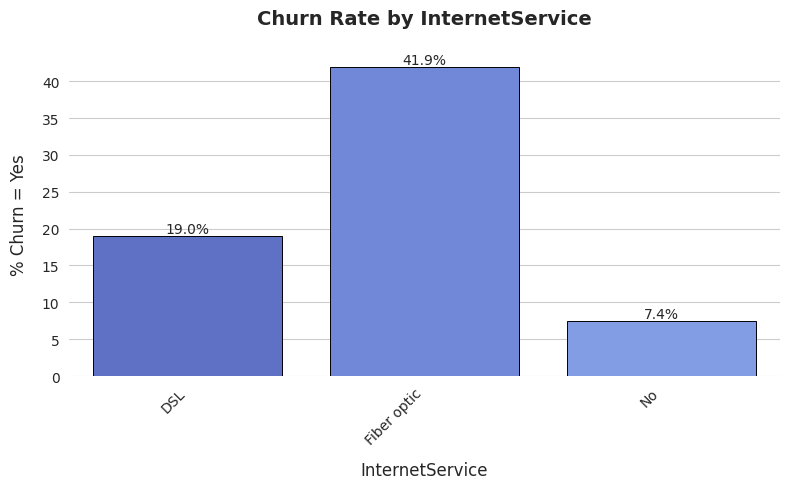

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


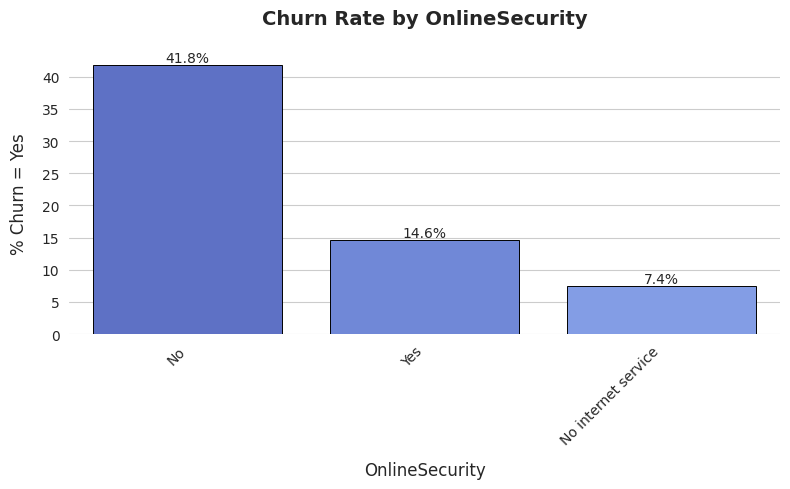

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


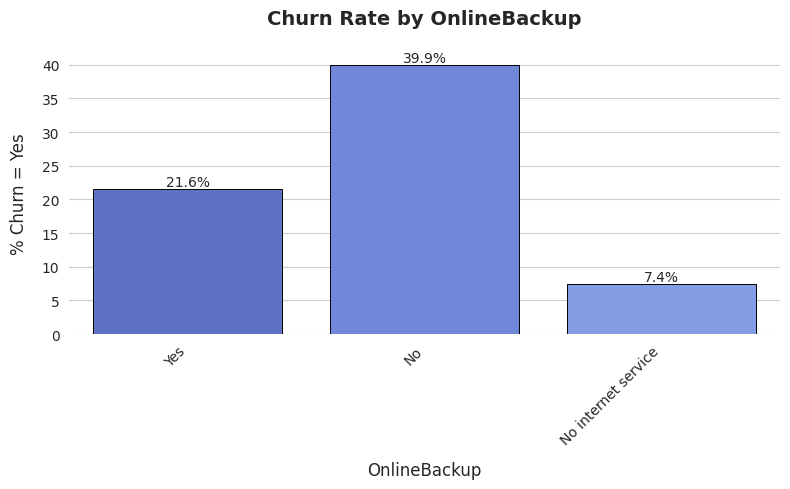

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


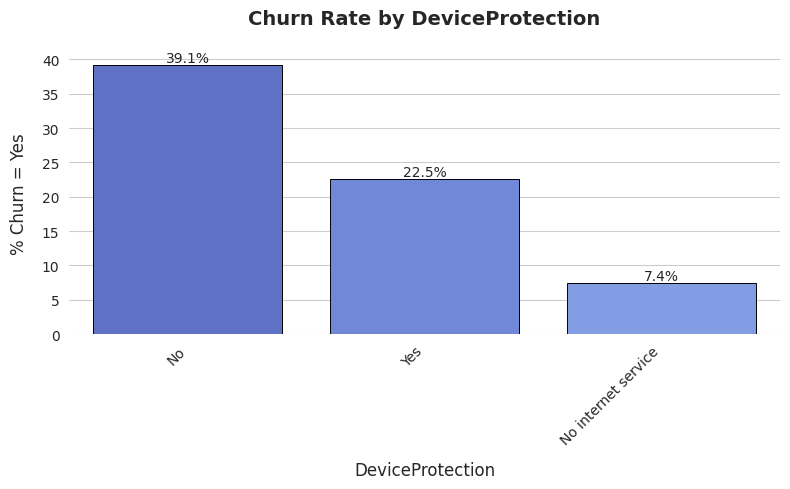

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


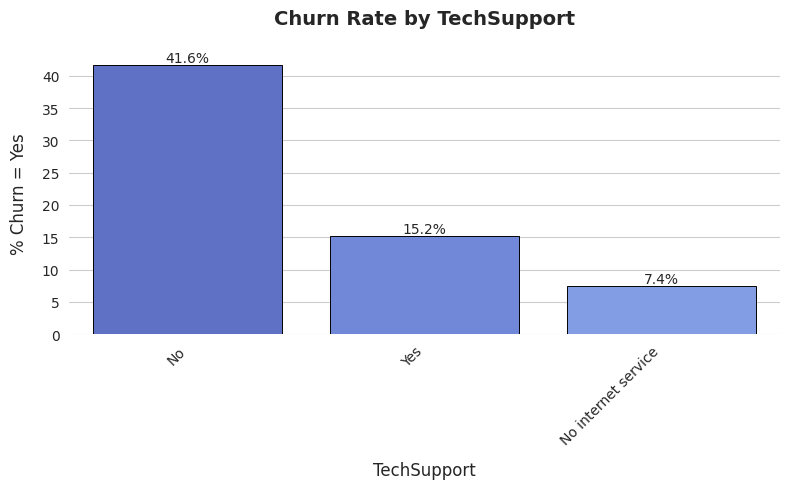

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


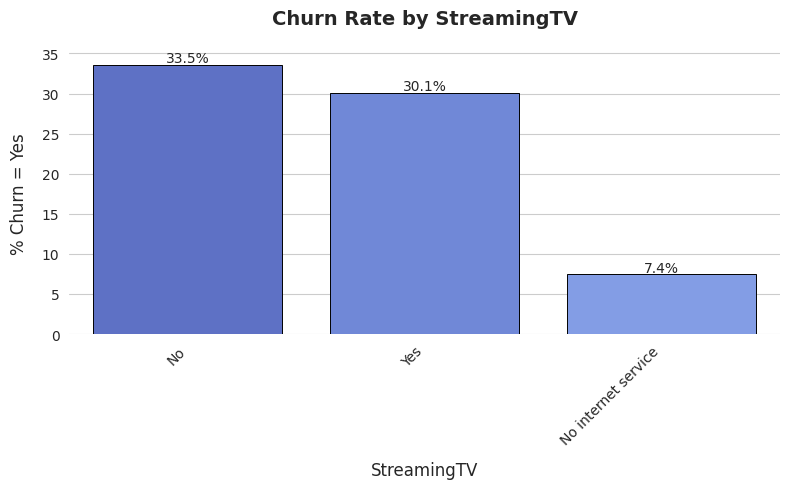

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


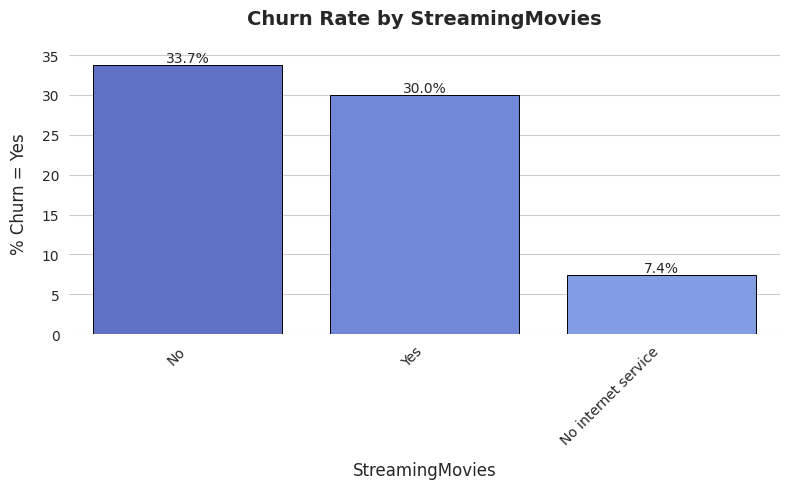

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (3), which may not be intended.
  ax = sns.barplot(


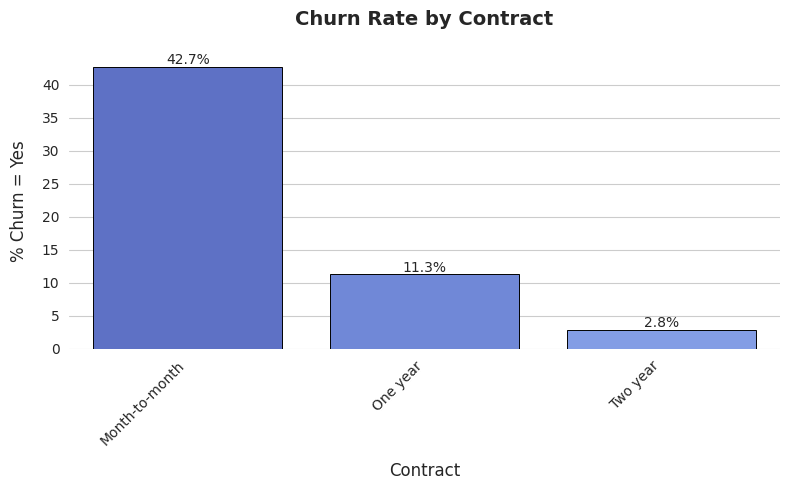

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (2), which may not be intended.
  ax = sns.barplot(


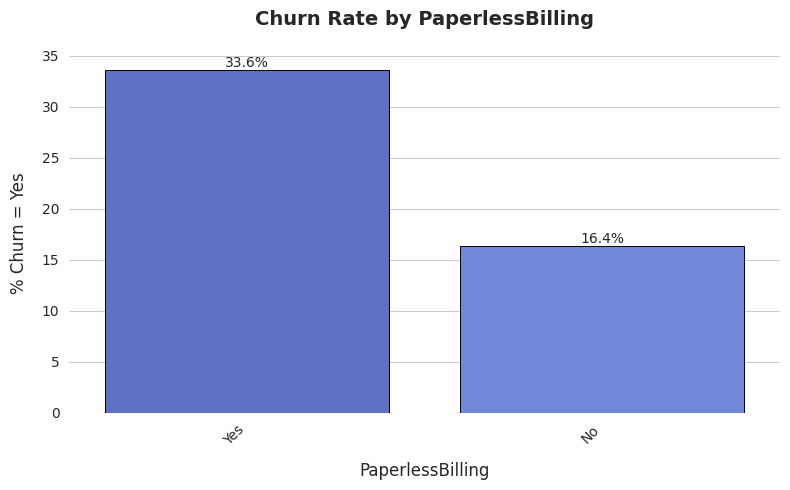

/tmp/ipykernel_47863/3170606341.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_47863/3170606341.py:27: UserWarning: The palette list has more values (16) than needed (4), which may not be intended.
  ax = sns.barplot(


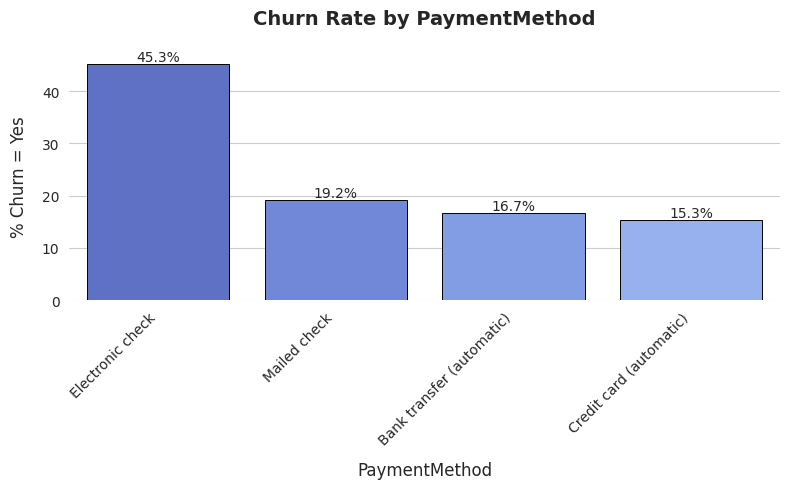

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set global style
sns.set_style("whitegrid")  # Background grid
plt.rcParams['font.family'] = 'DejaVu Sans'  # Clean font

cat_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
            'PhoneService', 'MultipleLines', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'Contract', 'PaperlessBilling', 'PaymentMethod']


# Define a color palette (e.g., 'coolwarm', 'viridis', or custom)
PALETTE = sns.color_palette("coolwarm", len(cat_vars))

# ...existing code...

for var in cat_vars:
    # Calculate churn rate per category (percentage of people who churned in each category)
    churn_rate = df.groupby(var)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    churn_rate = churn_rate.reindex(df[var].unique(), fill_value=0)  # Preserve order

    # Create figure
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        x=churn_rate.index, 
        y=churn_rate.values, 
        palette=PALETTE,  # Apply color palette
        edgecolor="black",  # Black borders on bars
        linewidth=0.7
    )
    
    # Customize title/labels
    plt.title(
        f'Churn Rate by {var}', 
        fontsize=14, 
        fontweight='bold', 
        pad=20
    )
    plt.xlabel(var, fontsize=12, labelpad=10)
    plt.ylabel('% Churn = Yes', fontsize=12, labelpad=10)
    
    # Rotate x-labels and adjust alignment
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add value annotations on top of bars
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.1f}%', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            xytext=(0, 5), 
            textcoords='offset points',
            fontsize=10
        )
    
    # Remove spines (optional)
    sns.despine(left=True, bottom=True)
    
    # Tight layout and show
    plt.tight_layout()
    plt.show()

**variable continue**

/tmp/ipykernel_47863/2981988490.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


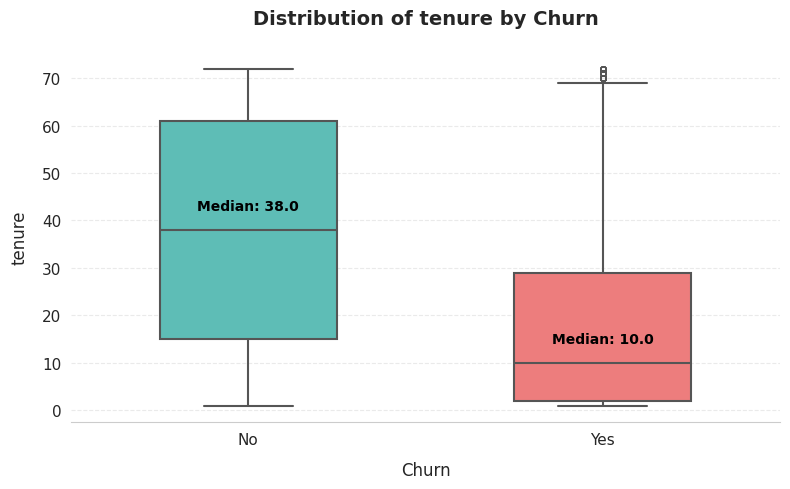

/tmp/ipykernel_47863/2981988490.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


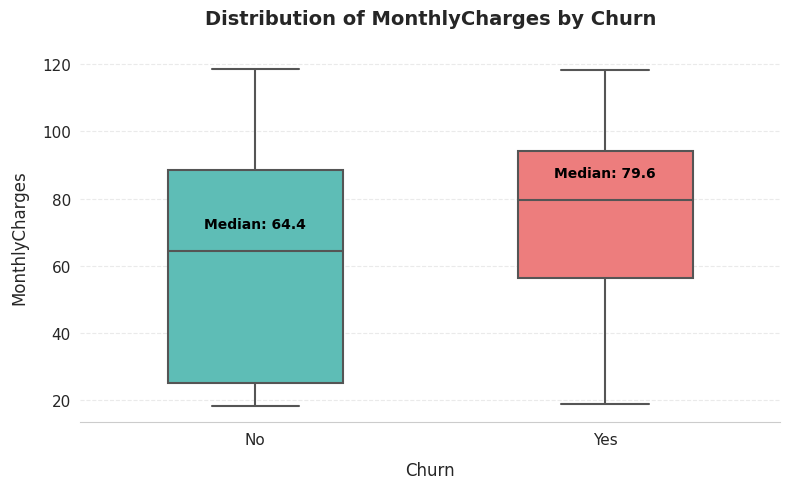

/tmp/ipykernel_47863/2981988490.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


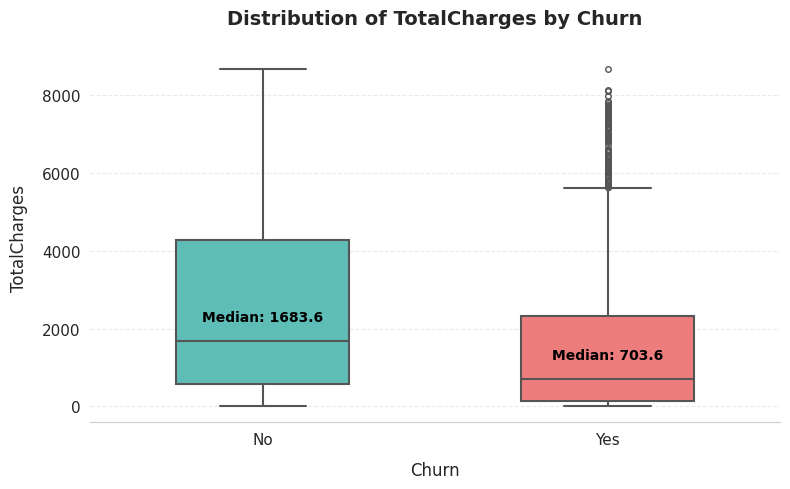

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set global style
sns.set_style("whitegrid")  # Clean background with grid
plt.rcParams['font.family'] = 'DejaVu Sans'  # Professional font

# Custom color palette for 'Churn' (Yes/No)
PALETTE = {"Yes": "#FF6B6B", "No": "#4ECDC4"}  # Red (Churn) vs Teal (No Churn)

num_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']

for var in num_vars:
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(
        x='Churn', 
        y=var, 
        data=df, 
        palette=PALETTE,  # Custom colors
        width=0.5,       # Adjust box width
        linewidth=1.5,   # Thicker borders
        fliersize=4      # Outlier marker size
    )
    
    # Titles and labels
    plt.title(
        f'Distribution of {var} by Churn', 
        fontsize=14, 
        fontweight='bold', 
        pad=20
    )
    plt.xlabel('Churn', fontsize=12, labelpad=10)
    plt.ylabel(var, fontsize=12, labelpad=10)
    
    # Customize ticks and grid
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.4)  # Horizontal grid lines
    
    # Add median annotations
    medians = df.groupby('Churn')[var].median().round(1)
    for i, (churn, median) in enumerate(medians.items()):
        ax.text(
            i, median + 0.05 * df[var].max(),  # Position slightly above median
            f'Median: {median}', 
            ha='center', 
            va='bottom',
            fontsize=10,
            color='black',
            weight='bold'
        )
    
    sns.despine(left=True)  # Remove left spine for cleaner look
    plt.tight_layout()
    plt.show()

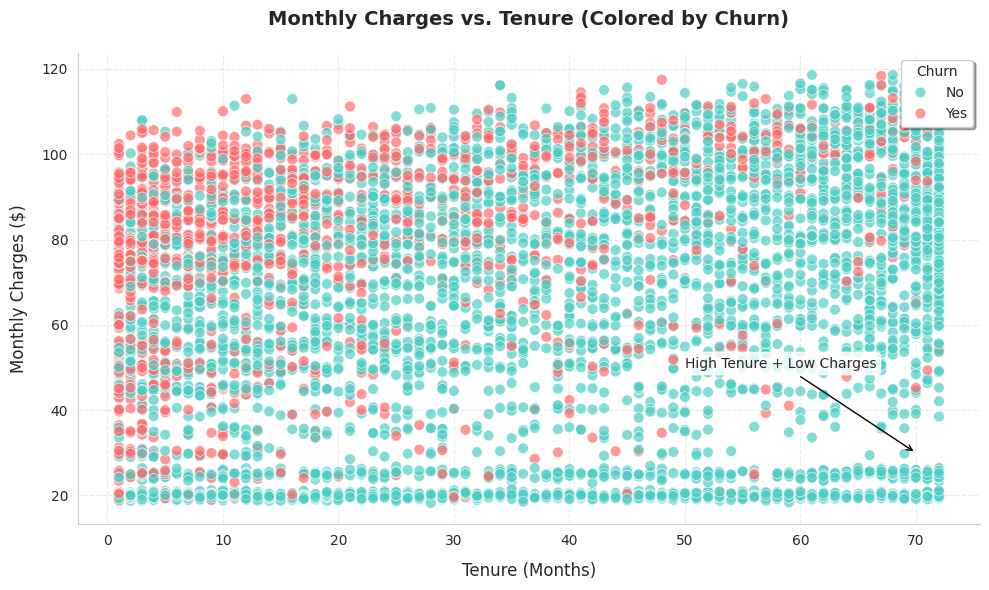

In [100]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='tenure', 
    y='MonthlyCharges', 
    hue='Churn', 
    data=df, 
    palette=PALETTE,  # Same palette as above
    alpha=0.7,       # Transparency for overlapping points
    s=60             # Point size
)

# Titles and labels
plt.title(
    'Monthly Charges vs. Tenure (Colored by Churn)', 
    fontsize=14, 
    fontweight='bold', 
    pad=20
)
plt.xlabel('Tenure (Months)', fontsize=12, labelpad=10)
plt.ylabel('Monthly Charges ($)', fontsize=12, labelpad=10)

# Legend and grid
plt.legend(
    title='Churn', 
    loc='upper right', 
    frameon=True, 
    shadow=True
)
plt.grid(linestyle='--', alpha=0.4)

# Annotate clusters (optional)
plt.annotate(
    'High Tenure + Low Charges', 
    xy=(70, 30), 
    xytext=(50, 50),
    arrowprops=dict(arrowstyle='->', color='black'),
    fontsize=10,
    bbox=dict(boxstyle='round', fc='white', alpha=0.8)
)

sns.despine()
plt.tight_layout()
plt.show()

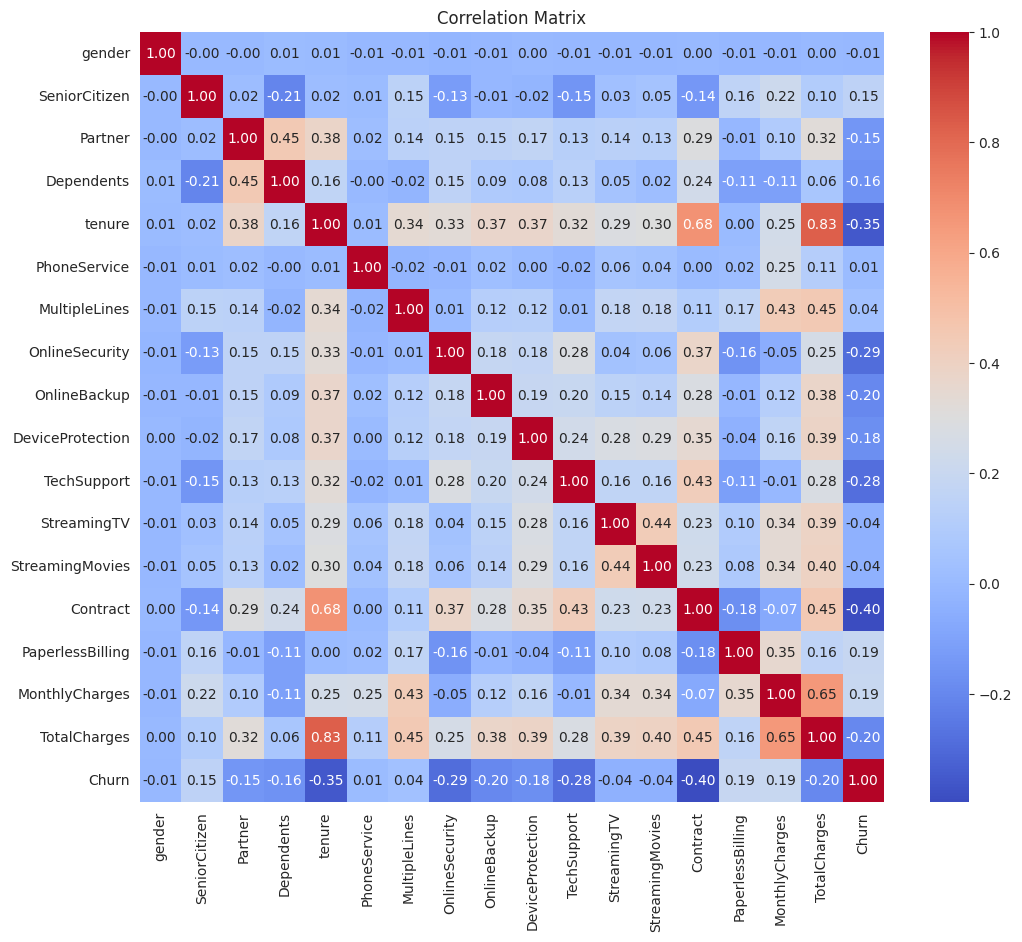

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
# Heatmap للعلاقات بين المتغيرات بعد الترميز
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.select_dtypes(include=['int64', 'float64']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


**scalling varaiables**

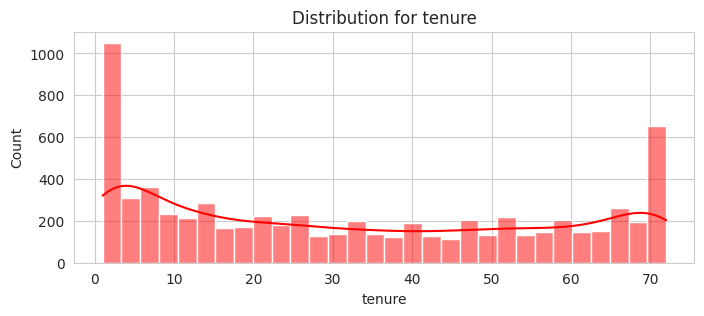

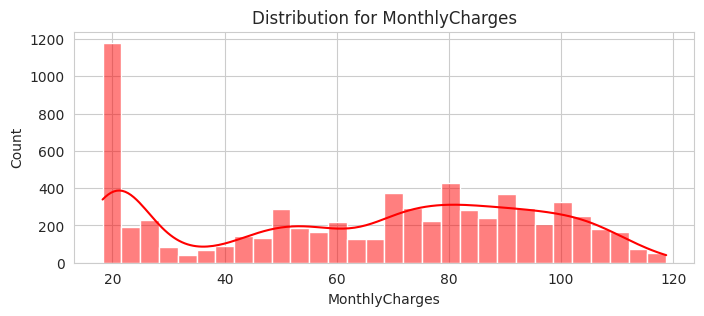

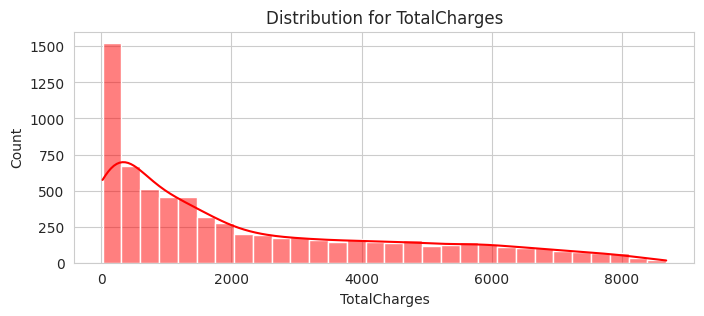

In [117]:
#we will solve the problem of unbalancing of continuous variables
#but before lets visualize the distplot of target variables
def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.histplot(frame[feature], color= color, kde=True, bins=30)

num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols: distplot(feat, df)

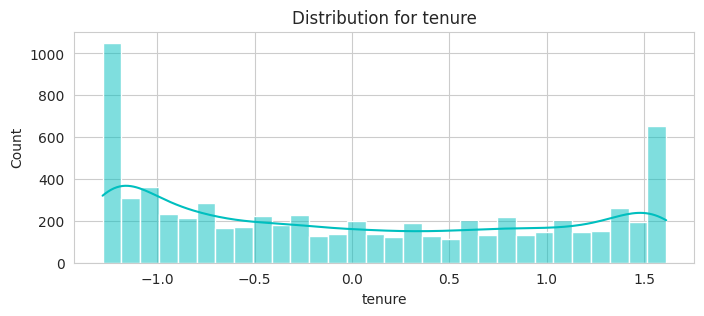

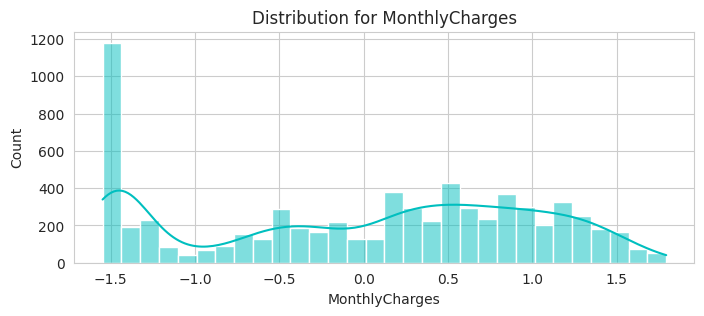

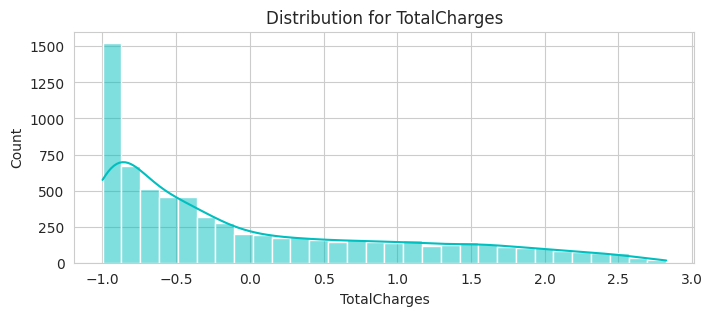

In [118]:
from sklearn.preprocessing import StandardScaler
#lets try to scale these variables
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].astype('float64')),
                       columns=num_cols)
for feat in num_cols: distplot(feat, df_std, color='c')

## 2 . Modélisation

### Naive Bays

              precision    recall  f1-score   support

    No Churn       0.89      0.71      0.79      1033
       Churn       0.49      0.76      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.74      1407



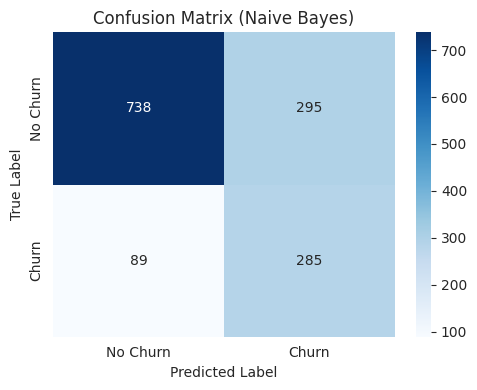

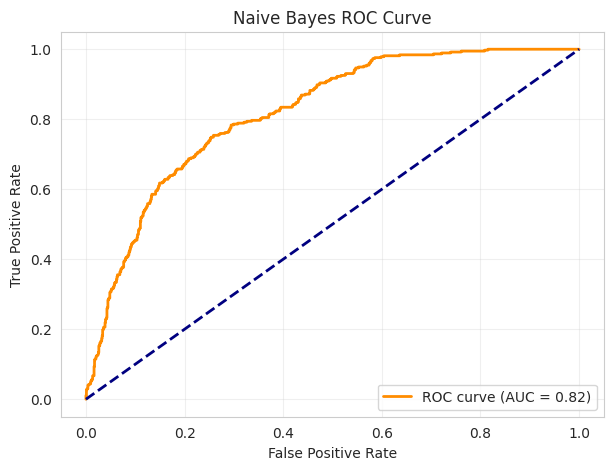

In [104]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


# eliminate 'customerID from the model features
df_model = df_clean.drop(columns=['customerID'])

# Replace the original columns with the scaled ones in df_model
for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    df_model[col] = df_std[col].values
    
# Remove one of the correlated features: let's drop 'TotalCharges'
features = [col for col in df_model.columns if col not in ['Churn', 'TotalCharges']]
X = df_model[features].values
y = df_model['Churn'].values

# Split the data (use the same split as before if possible, otherwise split here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_y_pred = nb_model.predict(X_test)
nb_y_proba = nb_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
acc = accuracy_score(y_test, nb_y_pred)
prec = precision_score(y_test, nb_y_pred)
rec = recall_score(y_test, nb_y_pred)
f1 = f1_score(y_test, nb_y_pred)
cm = confusion_matrix(y_test, nb_y_pred)

print(classification_report(y_test, nb_y_pred, target_names=['No Churn', 'Churn']))

#confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Naive Bayes)')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, nb_y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### logistic regression

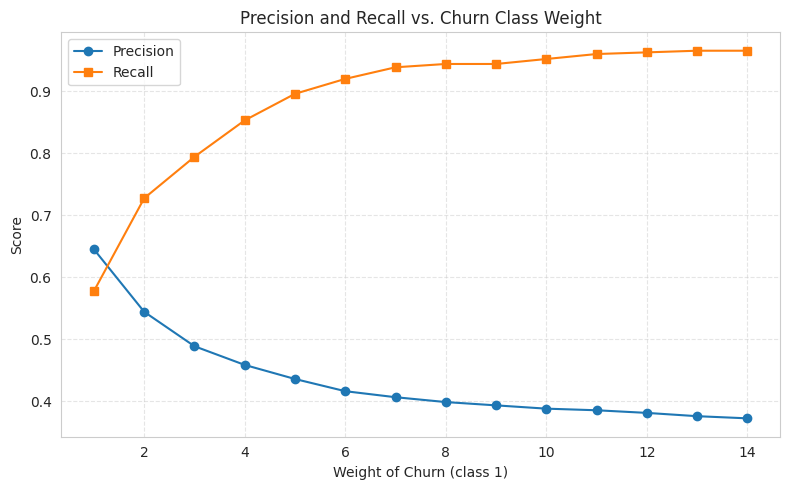

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score

weights = range(1, 15)
precisions = []
recalls_pos = []

for w in weights:
    logreg = LogisticRegression(max_iter=1000, class_weight={0: 1, 1: w}, solver='lbfgs')
    logreg.fit(X_train, y_train)
    lr_y_pred = logreg.predict(X_test)
    precisions.append(precision_score(y_test, lr_y_pred))
    recalls_pos.append(recall_score(y_test, lr_y_pred, pos_label=1))

plt.figure(figsize=(8, 5))
plt.plot(weights, precisions, marker='o', label='Precision')
plt.plot(weights, recalls_pos, marker='s', label='Recall')
plt.xlabel('Weight of Churn (class 1)')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Churn Class Weight')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

*on choisi le poids 6 donner a la variable la category churn*

              precision    recall  f1-score   support

    No Churn       0.95      0.53      0.68      1033
       Churn       0.42      0.92      0.57       374

    accuracy                           0.64      1407
   macro avg       0.68      0.73      0.63      1407
weighted avg       0.81      0.64      0.65      1407



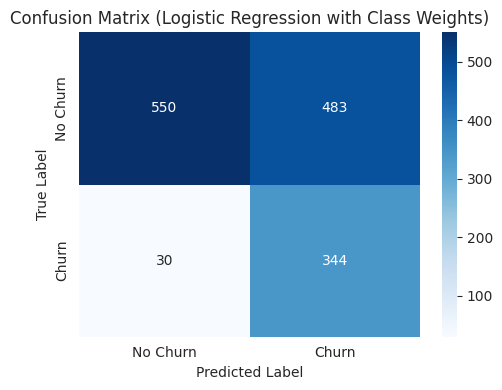

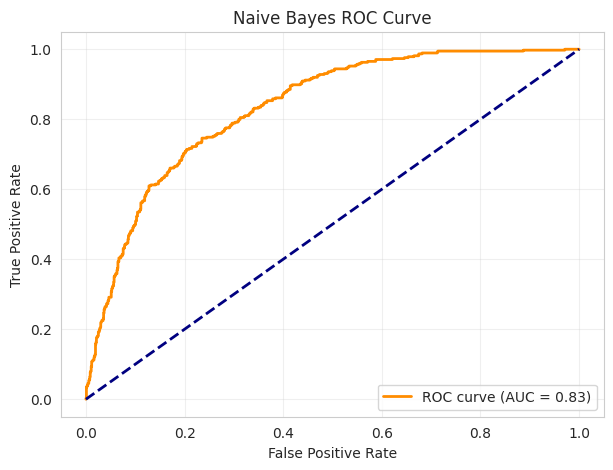

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define class weights: {class_label: weight}
class_weights = {0: 1, 1: 6}

# Fit logistic regression with class weights
logreg_weighted = LogisticRegression(
    max_iter=1000, class_weight=class_weights, solver='lbfgs'
)
logreg_weighted.fit(X_train, y_train)

# Predict and evaluate
lr_y_pred = logreg_weighted.predict(X_test)

print(classification_report(y_test, lr_y_pred, target_names=['No Churn', 'Churn']))

#confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, lr_y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Logistic Regression with Class Weights)')
plt.tight_layout()
plt.show()

#ROC Curve
lr_y_proba = logreg_weighted.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, lr_y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### SVM

In [107]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.svm import SVC


# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

# Initialize SVC with probability for ROC curve
svc = SVC(probability=True, random_state=42)

# تعريف scoring خاصة بـ recall على class 1
recall_scorer = make_scorer(recall_score, pos_label=1)

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    svc, param_grid, cv=5, scoring=recall_scorer, n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=  11.4s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=  11.8s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=  12.7s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=  13.0s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=  11.8s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=  12.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=  11.9s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=  11.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=  10.8s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=  11.4s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=  11.6s
[CV] END C=0.1, class_weight=balan

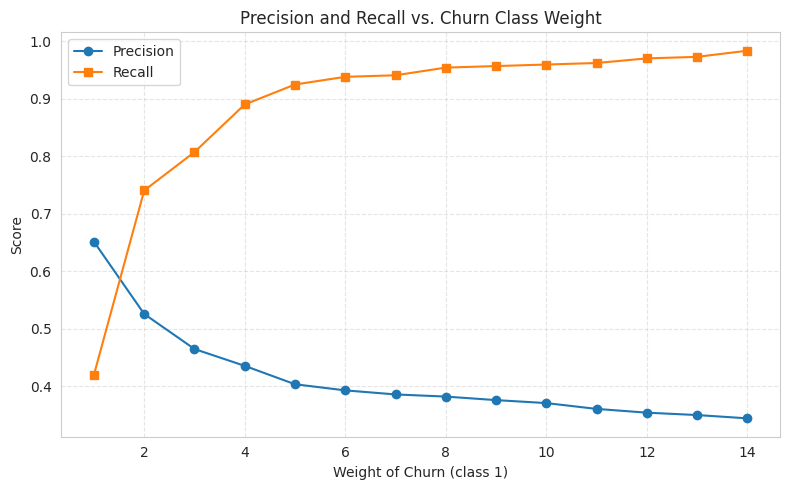

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import SVC

weights = range(1, 15)
precisions = []
recalls_pos = []

for w in weights:
    svm = SVC(kernel=grid_search.best_params_['kernel'], 
              C=grid_search.best_params_['C'], 
              gamma=grid_search.best_params_['gamma'], 
              class_weight={0: 1, 1: w}, 
              probability=True, 
              random_state=42)
    svm.fit(X_train, y_train)
    svm_y_pred = svm.predict(X_test)
    precisions.append(precision_score(y_test, svm_y_pred))
    recalls_pos.append(recall_score(y_test, svm_y_pred, pos_label=1))

plt.figure(figsize=(8, 5))
plt.plot(weights, precisions, marker='o', label='Precision')
plt.plot(weights, recalls_pos, marker='s', label='Recall')
plt.xlabel('Weight of Churn (class 1)')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Churn Class Weight')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

    No Churn       0.94      0.58      0.72      1033
       Churn       0.44      0.89      0.58       374

    accuracy                           0.66      1407
   macro avg       0.69      0.74      0.65      1407
weighted avg       0.80      0.66      0.68      1407



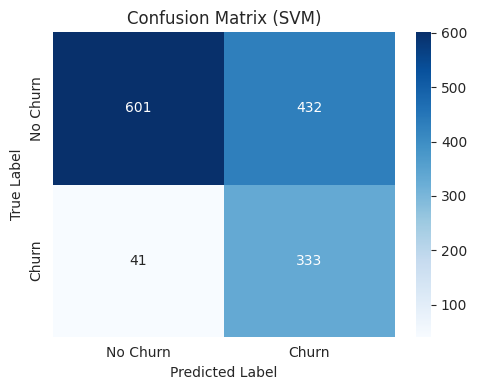

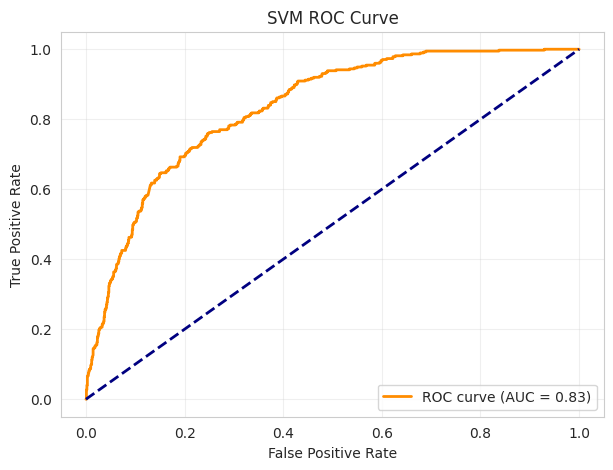

In [109]:
from sklearn.svm import SVC

#optimal weight from graph
optimal_weight = 4

# Fit SVM with probability estimates for ROC curve
svm_model = SVC(kernel=grid_search.best_params_['kernel'], 
              C=grid_search.best_params_['C'], 
              gamma=grid_search.best_params_['gamma'], 
              class_weight={0: 1, 1: optimal_weight}, 
              probability=True, 
              random_state=42)
svm_model.fit(X_train, y_train)

# Predict and evaluate
svm_y_pred = svm_model.predict(X_test)
print(classification_report(y_test, svm_y_pred, target_names=['No Churn', 'Churn']))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, svm_y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (SVM)')
plt.tight_layout()
plt.show()

# ROC Curve
svm_y_proba = svm_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, svm_y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)

# Use recall for the positive class as scoring
rf_grid_search = GridSearchCV(
    rf, rf_param_grid, cv=5, scoring=recall_scorer, n_jobs=-1, verbose=2
)
rf_grid_search.fit(X_train, y_train)

print("Best parameters:", rf_grid_search.best_params_)
print("Best recall score:", rf_grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END class_weight=balanced, max_depth=None, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=100; total time=   1.0s
[CV] END class_weight=balanced, max_depth=None, n_estimators=100; total time=   0.9s
[CV] END class_weight=balanced, max_depth=None, n_estimators=200; total time=   1.7s
[CV] END class_weight=balanced, max_depth=None, n_estimators=200; total time=   1.8s
[CV] END class_weight=balanced, max_depth=None, n_estimators=200; total time=   1.8s
[CV] END class_weight=balanced, max_depth=None, n_estimators=200; total time=   1.8s
[CV] END class_weight=balanced, max_depth=None, n_estimators=200; total time=   1.7s
[CV] END class_weight=balanced, max_depth=None, n_estimators=300; total time=   2.5s
[CV]

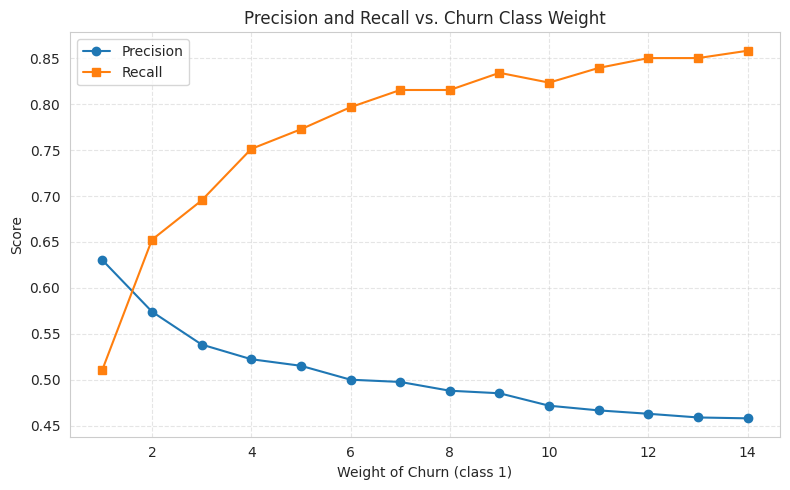

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

weights = range(1, 15)
precisions = []
recalls_pos = []

for w in weights:
    rf_model = RandomForestClassifier(
        n_estimators=rf_grid_search.best_params_['n_estimators'],
        max_depth=rf_grid_search.best_params_['max_depth'],
        class_weight={0: 1, 1: w},
        random_state=42)
    rf_model.fit(X_train, y_train)
    rf_y_pred = rf_model.predict(X_test)
    precisions.append(precision_score(y_test, rf_y_pred))
    recalls_pos.append(recall_score(y_test, rf_y_pred, pos_label=1))

plt.figure(figsize=(8, 5))
plt.plot(weights, precisions, marker='o', label='Precision')
plt.plot(weights, recalls_pos, marker='s', label='Recall')
plt.xlabel('Weight of Churn (class 1)')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Churn Class Weight')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

    No Churn       0.92      0.63      0.75      1033
       Churn       0.46      0.86      0.60       374

    accuracy                           0.69      1407
   macro avg       0.69      0.75      0.67      1407
weighted avg       0.80      0.69      0.71      1407



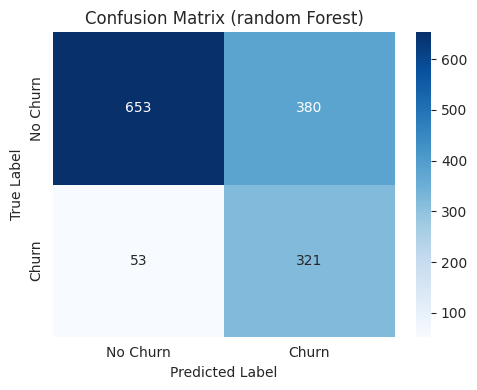

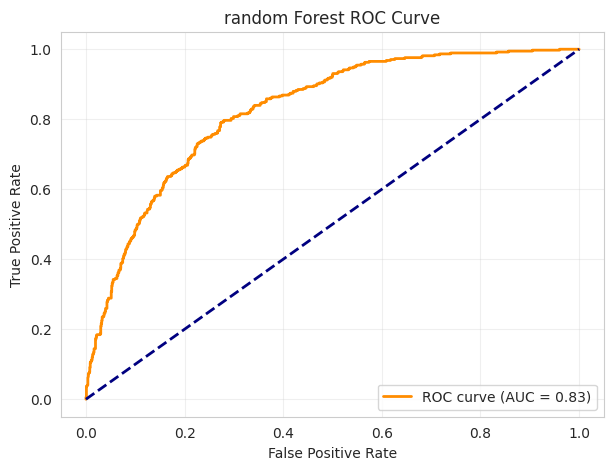

In [113]:
from sklearn.ensemble import RandomForestClassifier
#optimal weight from graph
optimal_weight = 14

# Fit SVM with probability estimates for ROC curve
rf_model = RandomForestClassifier(n_estimators=rf_grid_search.best_params_['n_estimators'], 
                                  max_depth=rf_grid_search.best_params_['max_depth'],
                                  class_weight={0: 1, 1: optimal_weight},
                                  random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_y_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_y_pred, target_names=['No Churn', 'Churn']))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, rf_y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (random Forest)')
plt.tight_layout()
plt.show()

# ROC Curve
rf_y_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('random Forest ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### comparison between models

In [115]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import pandas as pd

# Liste des modèles à comparer
models = {
    "Naive Bayes": nb_model,
    "Logistic Regression": logreg_weighted,
    "SVM": svm_model,
    "Random Forest": rf_model
}

# Initialiser la validation croisée
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Stocker les intervalles de confiance
results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision')
    mean = np.mean(scores)
    std = np.std(scores)
    ci_low = mean - 1.96 * std / np.sqrt(len(scores))
    ci_high = mean + 1.96 * std / np.sqrt(len(scores))
    results[name] = (mean, ci_low, ci_high)
    print(f"{name}: Precision moyenne = {mean:.3f}, IC 95% = [{ci_low:.3f}, {ci_high:.3f}]")

# Affichage sous forme de DataFrame pour plus de clarté
df_ci = pd.DataFrame(results, index=['mean', 'ci_low', 'ci_high']).T
df_ci

Naive Bayes: Precision moyenne = 0.517, IC 95% = [0.502, 0.531]
Logistic Regression: Precision moyenne = 0.433, IC 95% = [0.426, 0.441]
SVM: Precision moyenne = 0.448, IC 95% = [0.437, 0.458]
Random Forest: Precision moyenne = 0.479, IC 95% = [0.468, 0.489]


,mean,ci_low,ci_high
Naive Bayes,0.516706,0.502297,0.531116
Logistic Regression,0.433493,0.426483,0.440503
SVM,0.447510,0.437057,0.457963
Random Forest,0.478732,0.468237,0.489227
